In [301]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import time

In [303]:
train = pd.read_csv('../data/X_train.csv')
test =  pd.read_csv('../data/X_test.csv')
sample_submission = pd.read_csv('../data/sample_submission.csv')#This is a file with random numbers as predictions
                                                                #dans le futur fichier résultat ne pas mettre l'index

In [304]:
moyennes = train.mean()
print("Moyennes :")
print(moyennes)

# Minimum
minimums = train.min()
print("\nMinimums :")
print(minimums)

# Maximum
maximums = train.max()
print("\nMaximums :")
print(maximums)

Moyennes :
t             4.145262
x_1          -0.281288
y_1          -0.109516
v_x_1        -0.184127
v_y_1        -0.016500
x_2           0.007171
y_2          -0.082011
v_x_2         0.032477
v_y_2        -0.083608
x_3           0.274117
y_3           0.191527
v_x_3         0.151650
v_y_3         0.100108
Id       642499.500000
dtype: float64

Minimums :
t         0.000000
x_1     -30.823004
y_1     -17.857729
v_x_1   -72.993333
v_y_1   -23.109278
x_2     -30.833398
y_2     -52.450808
v_x_2   -25.895550
v_y_2   -48.289007
x_3     -17.439994
y_3     -33.159997
v_x_3   -30.970540
v_y_3   -25.509384
Id        0.000000
dtype: float64

Maximums :
t        1.000000e+01
x_1      1.634061e+01
y_1      2.627623e+01
v_x_1    2.350346e+01
v_y_1    3.467168e+01
x_2      1.550696e+01
y_2      3.567946e+01
v_x_2    7.271823e+01
v_y_2    2.311835e+01
x_3      6.165640e+01
y_3      2.773554e+01
v_x_3    2.596499e+01
v_y_3    4.828874e+01
Id       1.284999e+06
dtype: float64


#task 1.1

In [305]:
#Make sure you do not have the same initial positions in any two sets

df_t0 = train[train["t"] == 0].copy()
coords = ["x_1", "y_1", "x_2", "y_2", "x_3", "y_3"]
df_t0 = df_t0[~(df_t0[coords].eq(0).all(axis=1))]
duplicates = df_t0[df_t0.duplicated(subset=coords, keep=False)]

print(duplicates)#pas 2 fois la même position initiale


Empty DataFrame
Columns: [t, x_1, y_1, v_x_1, v_y_1, x_2, y_2, v_x_2, v_y_2, x_3, y_3, v_x_3, v_y_3, Id]
Index: []


In [306]:
#peut être rajouter d'autres méthodes que random
#split train en train et validation
def train_validation_split(df, train_size=0.8, validation_size=0.2, method="random"):
    traj_size=257
    if method == "random":
            
        n_traj = len(df) // traj_size  # nombre total de trajectoires
        traj_indices = np.arange(n_traj)
    
        np.random.shuffle(traj_indices)
    
        n_train = int(train_size * n_traj)
        n_val = int(validation_size * n_traj)
    
        if n_train + n_val > n_traj:
            raise ValueError("train_size + validation_size dépasse 1.0")
    
        train_traj_indices = traj_indices[:n_train]
        val_traj_indices = traj_indices[n_train:n_train+n_val]
    
        train_split = pd.concat([df.iloc[i*traj_size:(i+1)*traj_size] for i in train_traj_indices])
        validation_split = pd.concat([df.iloc[i*traj_size:(i+1)*traj_size] for i in val_traj_indices])
    
        return train_split, validation_split

In [311]:
train_after_split = train_validation_split(train)[0]
validation_after_split = train_validation_split(train)[1]

In [313]:
train_after_split.shape

(1028000, 14)

In [315]:
validation_after_split.shape

(257000, 14)

In [317]:
train_after_split.head(260)

,t,x_1,y_1,v_x_1,v_y_1,x_2,y_2,v_x_2,v_y_2,x_3,y_3,v_x_3,v_y_3,Id
703409,0.000000,1.000000,0.000000,0.000000,0.000000,-0.308626,0.227185,0.000000,0.000000,-0.691374,-0.227185,0.000000,0.000000,703409
703410,0.039062,0.999314,0.000039,-0.035125,0.001994,-0.309596,0.225454,-0.049840,-0.088827,-0.689718,-0.225493,0.084966,0.086833,703410
703411,0.078125,0.997255,0.000155,-0.070345,0.003939,-0.312548,0.220214,-0.101879,-0.180095,-0.684706,-0.220369,0.172223,0.176156,703411
703412,0.117188,0.993816,0.000345,-0.105752,0.005786,-0.317617,0.211316,-0.158708,-0.276679,-0.676199,-0.211661,0.264460,0.270893,703412
703413,0.156250,0.988989,0.000605,-0.141442,0.007482,-0.325055,0.198479,-0.223892,-0.382507,-0.663934,-0.199084,0.365334,0.375025,703413
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
703664,9.960940,3.503850,-0.256436,1.195691,-0.054298,-1.746854,0.013033,-1.344583,-0.221579,-1.756995,0.243403,0.148892,0.275877,703664
703665,10.000000,3.550502,-0.258553,1.192924,-0.054096,-1.798789,0.018426,-1.283495,0.499314,-1.751713,0.240127,0.090571,-0.445218,703665
1042906,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1042906
1042907,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1042907


In [319]:
validation_after_split.head(260)

,t,x_1,y_1,v_x_1,v_y_1,x_2,y_2,v_x_2,v_y_2,x_3,y_3,v_x_3,v_y_3,Id
2313,0.000000,1.000000,0.000000,0.000000,0.000000,-0.295683,0.250215,0.000000,0.000000,-0.704317,-0.250215,0.000000,0.000000,2313
2314,0.039062,0.999315,0.000046,-0.035066,0.002334,-0.296412,0.248714,-0.037392,-0.076999,-0.702904,-0.248759,0.072458,0.074665,2314
2315,0.078125,0.997259,0.000182,-0.070230,0.004627,-0.298623,0.244179,-0.076184,-0.155594,-0.698636,-0.244361,0.146414,0.150967,2315
2316,0.117188,0.993826,0.000406,-0.105590,0.006835,-0.302402,0.236514,-0.117969,-0.237594,-0.691424,-0.236920,0.223560,0.230759,2316
2317,0.156250,0.989006,0.000714,-0.141249,0.008915,-0.307905,0.225543,-0.164799,-0.325309,-0.681102,-0.226257,0.306048,0.316394,2317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2568,9.960940,0.939510,0.035259,0.051884,0.076718,-0.497854,0.202309,0.316346,-0.842524,-0.441656,-0.237568,-0.368229,0.765806,2568
2569,10.000000,0.940796,0.038224,0.013890,0.075078,-0.484651,0.165043,0.359240,-1.079933,-0.456144,-0.203266,-0.373130,1.004855,2569
926742,0.000000,1.000000,0.000000,0.000000,0.000000,-0.262203,0.439303,0.000000,0.000000,-0.737797,-0.439303,0.000000,0.000000,926742
926743,0.039062,0.999366,0.000082,-0.032458,0.004208,-0.262164,0.438490,0.002012,-0.041641,-0.737202,-0.438572,0.030446,0.037433,926743


In [321]:
number_lines=train.shape[0]
time_interval=257
index_begin_trajectory=np.arange(0, number_lines,time_interval)
index_begin_trajectory

array([      0,     257,     514, ..., 1284229, 1284486, 1284743])

In [323]:
#donne l'index du point initial d'un index
def get_index_initial_point(id, idx=index_begin_trajectory):
    initial_idx = max(i for i in idx if i <= id)
    return initial_idx

In [325]:
get_index_initial_point(800)

771

#task 1.2

In [327]:
def replicate_initial_position_by_block(df):
    
    coords = ["x_1", "y_1", "v_x_1", "v_y_1", "x_2", "y_2", "v_x_2", "v_y_2", "x_3", "y_3", "v_x_3", "v_y_3"] 
    block_size = 257 
    n = len(df) 
    train_after_split_copy = df.copy(deep=True) 
    
    for i in range(0, n, block_size): 
        end_idx = min(i + block_size, n) 
        first_row = train_after_split_copy.iloc[i][coords].values 
        train_after_split_copy.iloc[i:end_idx, train_after_split_copy.columns.get_indexer(coords)] = first_row
    
    return train_after_split_copy

In [329]:
train_entry=replicate_initial_position_by_block(train_after_split)

In [330]:
train_entry.head(260)

,t,x_1,y_1,v_x_1,v_y_1,x_2,y_2,v_x_2,v_y_2,x_3,y_3,v_x_3,v_y_3,Id
703409,0.000000,1.0,0.0,0.0,0.0,-0.308626,0.227185,0.0,0.0,-0.691374,-0.227185,0.0,0.0,703409
703410,0.039062,1.0,0.0,0.0,0.0,-0.308626,0.227185,0.0,0.0,-0.691374,-0.227185,0.0,0.0,703410
703411,0.078125,1.0,0.0,0.0,0.0,-0.308626,0.227185,0.0,0.0,-0.691374,-0.227185,0.0,0.0,703411
703412,0.117188,1.0,0.0,0.0,0.0,-0.308626,0.227185,0.0,0.0,-0.691374,-0.227185,0.0,0.0,703412
703413,0.156250,1.0,0.0,0.0,0.0,-0.308626,0.227185,0.0,0.0,-0.691374,-0.227185,0.0,0.0,703413
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
703664,9.960940,1.0,0.0,0.0,0.0,-0.308626,0.227185,0.0,0.0,-0.691374,-0.227185,0.0,0.0,703664
703665,10.000000,1.0,0.0,0.0,0.0,-0.308626,0.227185,0.0,0.0,-0.691374,-0.227185,0.0,0.0,703665
1042906,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,1042906
1042907,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,1042907


In [331]:
train_after_split.head(260)

,t,x_1,y_1,v_x_1,v_y_1,x_2,y_2,v_x_2,v_y_2,x_3,y_3,v_x_3,v_y_3,Id
703409,0.000000,1.000000,0.000000,0.000000,0.000000,-0.308626,0.227185,0.000000,0.000000,-0.691374,-0.227185,0.000000,0.000000,703409
703410,0.039062,0.999314,0.000039,-0.035125,0.001994,-0.309596,0.225454,-0.049840,-0.088827,-0.689718,-0.225493,0.084966,0.086833,703410
703411,0.078125,0.997255,0.000155,-0.070345,0.003939,-0.312548,0.220214,-0.101879,-0.180095,-0.684706,-0.220369,0.172223,0.176156,703411
703412,0.117188,0.993816,0.000345,-0.105752,0.005786,-0.317617,0.211316,-0.158708,-0.276679,-0.676199,-0.211661,0.264460,0.270893,703412
703413,0.156250,0.988989,0.000605,-0.141442,0.007482,-0.325055,0.198479,-0.223892,-0.382507,-0.663934,-0.199084,0.365334,0.375025,703413
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
703664,9.960940,3.503850,-0.256436,1.195691,-0.054298,-1.746854,0.013033,-1.344583,-0.221579,-1.756995,0.243403,0.148892,0.275877,703664
703665,10.000000,3.550502,-0.258553,1.192924,-0.054096,-1.798789,0.018426,-1.283495,0.499314,-1.751713,0.240127,0.090571,-0.445218,703665
1042906,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1042906
1042907,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1042907


In [332]:
X_train = train_entry[["t", "x_1", "y_1", "x_2", "y_2", "x_3", "y_3"]].values
Y_train = train_after_split[["x_1", "y_1", "x_2", "y_2", "x_3", "y_3"]].values


# Pipeline : standardisation + régression linéaire
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("regressor", LinearRegression())
])

# Entraînement
pipeline.fit(X_train, Y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor', LinearRegression())])

In [333]:
regressor = pipeline.named_steps["regressor"]

# Matrice des coefficients (shape = nb_outputs x nb_inputs)
print("Coefficients (W):")
print(regressor.coef_)

# Biais (intercept b)
print("Intercept (b):")
print(regressor.intercept_)


Coefficients (W):
[[-5.13419344e-01 -1.06547941e+10  7.40958992e+03 -6.89008757e+10
   5.11894629e+10 -6.93153142e+10  5.11894629e+10]
 [-4.47989452e-02  2.04682932e+10 -3.39882458e+02  1.32361387e+11
  -3.20629733e+09  1.33157540e+11 -3.20629733e+09]
 [ 7.13773597e-02  4.79675897e+09 -2.94020420e+03  3.10189845e+10
  -2.03369575e+10  3.12055635e+10 -2.03369575e+10]
 [-2.11789020e-01 -3.92642159e+09  9.72966192e+02 -2.53908131e+10
   6.83033680e+09 -2.55435387e+10  6.83033680e+09]
 [ 4.42041985e-01  5.85803515e+09 -4.46938572e+03  3.78818912e+10
  -3.08525055e+10  3.81097506e+10 -3.08525055e+10]
 [ 2.56587966e-01 -1.65418716e+10 -6.33083732e+02 -1.06970574e+11
  -3.62403947e+09 -1.07614001e+11 -3.62403947e+09]]
Intercept (b):
[-0.269007   -0.10899611  0.00144762 -0.07604932  0.26755938  0.18504543]


In [334]:
validation_entry=replicate_initial_position_by_block(validation_after_split)
validation_entry.head(260)

,t,x_1,y_1,v_x_1,v_y_1,x_2,y_2,v_x_2,v_y_2,x_3,y_3,v_x_3,v_y_3,Id
2313,0.000000,1.0,0.0,0.0,0.0,-0.295683,0.250215,0.0,0.0,-0.704317,-0.250215,0.0,0.0,2313
2314,0.039062,1.0,0.0,0.0,0.0,-0.295683,0.250215,0.0,0.0,-0.704317,-0.250215,0.0,0.0,2314
2315,0.078125,1.0,0.0,0.0,0.0,-0.295683,0.250215,0.0,0.0,-0.704317,-0.250215,0.0,0.0,2315
2316,0.117188,1.0,0.0,0.0,0.0,-0.295683,0.250215,0.0,0.0,-0.704317,-0.250215,0.0,0.0,2316
2317,0.156250,1.0,0.0,0.0,0.0,-0.295683,0.250215,0.0,0.0,-0.704317,-0.250215,0.0,0.0,2317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2568,9.960940,1.0,0.0,0.0,0.0,-0.295683,0.250215,0.0,0.0,-0.704317,-0.250215,0.0,0.0,2568
2569,10.000000,1.0,0.0,0.0,0.0,-0.295683,0.250215,0.0,0.0,-0.704317,-0.250215,0.0,0.0,2569
926742,0.000000,1.0,0.0,0.0,0.0,-0.262203,0.439303,0.0,0.0,-0.737797,-0.439303,0.0,0.0,926742
926743,0.039062,1.0,0.0,0.0,0.0,-0.262203,0.439303,0.0,0.0,-0.737797,-0.439303,0.0,0.0,926743


In [335]:
validation_after_split.head(260)

,t,x_1,y_1,v_x_1,v_y_1,x_2,y_2,v_x_2,v_y_2,x_3,y_3,v_x_3,v_y_3,Id
2313,0.000000,1.000000,0.000000,0.000000,0.000000,-0.295683,0.250215,0.000000,0.000000,-0.704317,-0.250215,0.000000,0.000000,2313
2314,0.039062,0.999315,0.000046,-0.035066,0.002334,-0.296412,0.248714,-0.037392,-0.076999,-0.702904,-0.248759,0.072458,0.074665,2314
2315,0.078125,0.997259,0.000182,-0.070230,0.004627,-0.298623,0.244179,-0.076184,-0.155594,-0.698636,-0.244361,0.146414,0.150967,2315
2316,0.117188,0.993826,0.000406,-0.105590,0.006835,-0.302402,0.236514,-0.117969,-0.237594,-0.691424,-0.236920,0.223560,0.230759,2316
2317,0.156250,0.989006,0.000714,-0.141249,0.008915,-0.307905,0.225543,-0.164799,-0.325309,-0.681102,-0.226257,0.306048,0.316394,2317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2568,9.960940,0.939510,0.035259,0.051884,0.076718,-0.497854,0.202309,0.316346,-0.842524,-0.441656,-0.237568,-0.368229,0.765806,2568
2569,10.000000,0.940796,0.038224,0.013890,0.075078,-0.484651,0.165043,0.359240,-1.079933,-0.456144,-0.203266,-0.373130,1.004855,2569
926742,0.000000,1.000000,0.000000,0.000000,0.000000,-0.262203,0.439303,0.000000,0.000000,-0.737797,-0.439303,0.000000,0.000000,926742
926743,0.039062,0.999366,0.000082,-0.032458,0.004208,-0.262164,0.438490,0.002012,-0.041641,-0.737202,-0.438572,0.030446,0.037433,926743


In [336]:
X_validation = validation_entry[["t","x_1", "y_1", "x_2", "y_2", "x_3", "y_3"]].values
Y_validation = validation_after_split[["x_1", "y_1", "x_2", "y_2", "x_3", "y_3"]].values
Y_validation_pred = pipeline.predict(X_validation)
Y_validation_pred


array([[ 4.44839747e-01,  9.70769195e-02, -2.96443108e-02,
         1.97400335e-01, -4.15191050e-01, -2.94481381e-01],
       [ 4.38583644e-01,  9.65276031e-02, -2.87764672e-02,
         1.94821600e-01, -4.09808512e-01, -2.91360959e-01],
       [ 4.32335170e-01,  9.59859161e-02, -2.79067162e-02,
         1.92241911e-01, -4.04425974e-01, -2.88232907e-01],
       ...,
       [-1.21022992e+00, -4.64676905e-01, -1.44841300e-04,
        -4.38577990e-01,  1.21036706e+00,  9.03268309e-01],
       [-1.21648602e+00, -4.65210963e-01,  7.24909676e-04,
        -4.41156725e-01,  1.21575342e+00,  9.06396361e-01],
       [-1.22274212e+00, -4.65760279e-01,  1.59466065e-03,
        -4.43735461e-01,  1.22113214e+00,  9.09524412e-01]])

In [337]:
def plot_y_yhat(y_test,y_pred, plot_title = "plot"):
    labels = ['x_1','y_1','x_2','y_2','x_3','y_3']
    MAX = 500
    if len(y_test) > MAX:
        idx = np.random.choice(len(y_test),MAX, replace=False)
    else:
        idx = np.arange(len(y_test))
    plt.figure(figsize=(10,10))
    for i in range(6):
        x0 = np.min(y_test[idx,i])
        x1 = np.max(y_test[idx,i])
        plt.subplot(3,2,i+1)
        plt.scatter(y_test[idx,i],y_pred[idx,i])
        plt.xlabel('True '+labels[i])
        plt.ylabel('Predicted '+labels[i])
        plt.plot([x0,x1],[x0,x1],color='red')
        plt.axis('square')
    plt.show()

In [338]:
Y_validation

array([[ 1.00000000e+00,  0.00000000e+00, -2.95683491e-01,
         2.50214973e-01, -7.04316509e-01, -2.50214973e-01],
       [ 9.99315282e-01,  4.56572542e-05, -2.96411587e-01,
         2.48713621e-01, -7.02903695e-01, -2.48759279e-01],
       [ 9.97259213e-01,  1.81819126e-04, -2.98622907e-01,
         2.44178730e-01, -6.98636306e-01, -2.44360549e-01],
       ...,
       [ 8.52292398e-02, -6.07153559e-01, -4.34356371e-01,
         4.02289581e-01,  3.49127132e-01,  2.04863978e-01],
       [ 5.44152878e-02, -6.20730616e-01, -4.39157729e-01,
         3.76148458e-01,  3.84742441e-01,  2.44582158e-01],
       [ 2.36872021e-02, -6.31533032e-01, -4.41248066e-01,
         3.48552376e-01,  4.17560864e-01,  2.82980656e-01]])

In [339]:
Y_val_df = pd.DataFrame(Y_validation, columns=["x_1","y_1","x_2","y_2","x_3","y_3"])

# Calculer moyenne, min et max
summary_Y_val = pd.DataFrame({
    "mean": Y_val_df.mean(),
    "min": Y_val_df.min(),
    "max": Y_val_df.max()
})

print(summary_Y_val)

         mean        min        max
x_1 -0.272655 -21.071175   9.928578
y_1 -0.132089 -13.900622  11.247081
x_2  0.002308  -9.739695  11.402463
y_2 -0.064262 -13.834917  11.553553
x_3  0.270347  -7.696730  19.010092
y_3  0.196351  -7.921066  27.735539


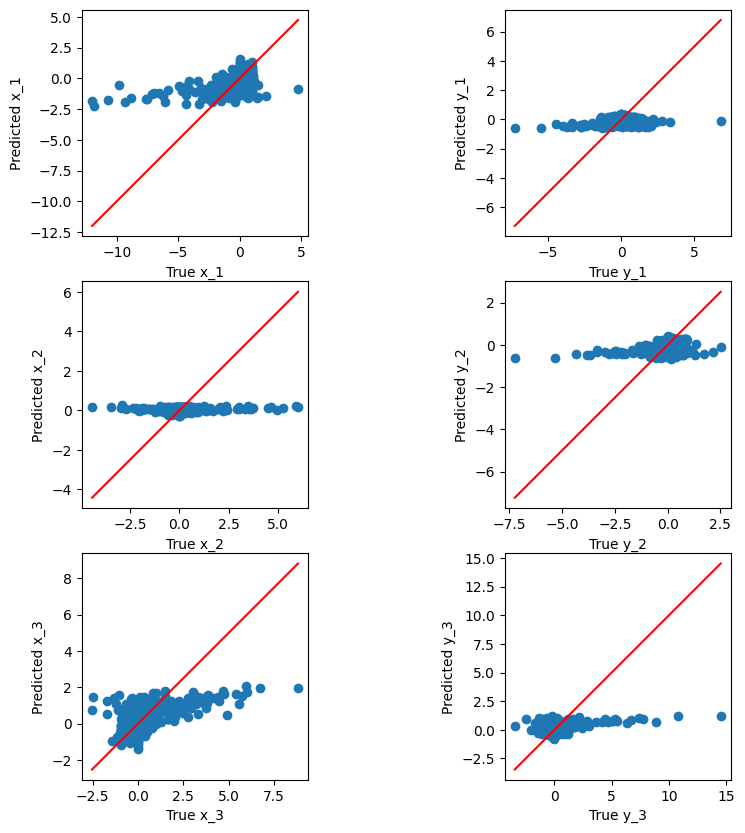

In [353]:
#Prends des points randoms si >500 points
plot_y_yhat(Y_validation,Y_validation_pred, plot_title = "plot")